In [445]:
# import librarties 
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import nltk 
import spacy
import string
from gensim.models import KeyedVectors
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt 

In [451]:
random.seed(134)
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 3
MAX_VOCAB_SIZE = 50000

# Data Processing

### Build vocab from pretrained word embeddings

In [343]:
# build vocab from fasttext embeddings 

def build_vocab(word2vec_source, max_vocab_size): 
    """ Takes pretrained word2vec source path, limits to max_vocab_size, and returns:  
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices 
        - word_emb: dictionary representing word embeddings 
    """
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_source, limit=max_vocab_size)
    id2token = word2vec_model.index2word
    token2id = dict(zip(id2token, range(2, 2+len(id2token))))
    id2token = ['<pad>', '<unk>'] + id2token 
    word_emb = {token2id[w]: word2vec_model[w] for w in word2vec_model.vocab}

    return id2token, token2id, word_emb 

In [344]:
id2token, token2id, word_emb = build_vocab('fasttext_word2vec/wiki-news-300d-1M.vec', MAX_VOCAB_SIZE)

In [345]:
# convert word_emb from dict to matrix 
pretrained_weights = np.zeros((MAX_VOCAB_SIZE+2, 300))
for idx in word_emb: 
    try: 
        pretrained_weights[idx] = word_emb[idx]
    except KeyError: 
        pretrained_weights[idx] = np.random.normal(size=(300,))
pretrained_weights = torch.from_numpy(pretrained_weights.astype(np.float32))

### Load data and convert to indices

In [346]:
# load data into pandas dataframe 
snli_train = pd.read_table('hw2_data/snli_train.tsv')
snli_val = pd.read_table('hw2_data/snli_val.tsv')
mnli_train = pd.read_table('hw2_data/mnli_train.tsv')
mnli_val = pd.read_table('hw2_data/mnli_val.tsv')
print(len(snli_train), len(snli_val), len(mnli_train), len(mnli_val))

100000 1000 20000 5000


In [347]:
snli_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [348]:
# helper methods to convert pandas df to lists of word indices and labels 

label_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

def token_to_index_datum(datum_tokens, token2id): 
    """ Converts a list of tokens and converts it to a list of token indices for one datum """ 
    index_list = [token2id[token] if token in token2id else UNK_IDX for token in datum_tokens]
    return index_list 

def df_to_list(data_df, token2id): 
    """ Takes train/val data as pandas df and returns: 
        - list of lists of word indices representing first sentence 
        - list of lists of word indices representing second sentence 
        - list of ground truth labels indicating entailment/contradiction/neutrality of two sentences 
    """
    sent1 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence1'].tolist()] 
    sent2 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence2'].tolist()] 
    labels = [label_dict[label] for label in data_df['label'].tolist()] 
    return sent1, sent2, labels

In [349]:
# convert data to indices 
snli_train_sent1, snli_train_sent2, snli_train_labels = df_to_list(snli_train, token2id)
snli_val_sent1, snli_val_sent2, snli_val_labels = df_to_list(snli_val, token2id)
mnli_train_sent1, mnli_train_sent2, mnli_train_labels = df_to_list(mnli_train, token2id)
mnli_val_sent1, mnli_val_sent2, mnli_val_labels = df_to_list(mnli_val, token2id)

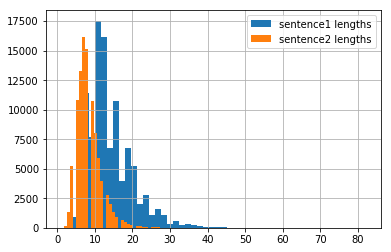

In [450]:
# check distribution of sentence lengths 
snli_train['sentence1'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='sentence1 lengths')
snli_train['sentence2'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='sentence2 lengths')
plt.legend()

In [452]:
# based on results above, we set our max_sentence_length to 40 which covers all of sentence2 and most of sentence1 
MAX_SENTENCE_LENGTH = 40

### Build PyTorch Dataloader 

In [350]:
# helper functions to create dataloader 

class SNLI_Dataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset    
    """
    
    def __init__(self, sent1_list, sent2_list, label_list): 
        """ 
        Initialize dataset by passing in the sent and label lists, along with max_sent_length 
        """
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list 
        self.label_list = label_list
        assert (len(self.sent1_list) == len(self.sent2_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.label_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, lengths of lists, and label of the data point
        """
        sent1_idx = self.sent1_list[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.sent2_list[key][:MAX_SENTENCE_LENGTH]    
        sent1_len = len(sent1_idx)
        sent2_len = len(sent2_idx)
        label = self.label_list[key]
        return [sent1_idx, sent2_idx, sent1_len, sent2_len, label]
    
def collate_func(batch): 
    """Customized function for DataLoader that dynamically pads the batch 
       so that all data have the same length""" 
    
    sents1 = [] 
    sents2 = [] 
    sent1_lens = [] 
    sent2_lens = [] 
    labels = [] 

    for datum in batch:
        sent1_lens.append(datum[2])
        sent2_lens.append(datum[3])
        labels.append(datum[4])
        
        # pad data before appending 
        padded_vec1 = np.pad(array=np.array(datum[0]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[2])), 
                             mode = 'constant', constant_values = 0)
        padded_vec2 = np.pad(array=np.array(datum[1]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[3])), 
                             mode = 'constant', constant_values = 0)
        sents1.append(padded_vec1)
        sents2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(sents1)), torch.from_numpy(np.array(sents2)), 
            torch.LongTensor(sent1_lens), torch.LongTensor(sent2_lens), torch.LongTensor(labels)]

def create_data_loader(sent1_list, sent2_list, label_list): 
    """ Takes index lists of sentence1, setence2, and labels for a given dataset and returns a data loader """
    data_set = SNLI_Dataset(sent1_list, sent2_list, label_list)
    data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=BATCH_SIZE, 
                                              collate_fn=collate_func, shuffle=False)
    return data_loader 

In [351]:
# create data loaders 
snli_train_loader = create_data_loader(snli_train_sent1, snli_train_sent2, snli_train_labels)
snli_val_loader = create_data_loader(snli_val_sent1, snli_val_sent2, snli_val_labels)
mnli_train_loader = create_data_loader(mnli_train_sent1, mnli_train_sent2, mnli_train_labels)
mnli_val_loader = create_data_loader(mnli_val_sent1, mnli_val_sent2, mnli_val_labels)

In [352]:
for i, (sent1_idx, sent2_idx, sent1_len, sent2_len, label) in enumerate(snli_train_loader):
    print(i)
    print(sent1_idx)
    print(sent2_idx)
    print(sent1_len)
    print(sent2_len)
    print(label)
    break 

0
tensor([[  106,   802,  1830,     8,     9,  6265,  7167,  4388,    17,     9,
         12229,  5335,     9,   563,     6,   358,     4,     0,     0,     0],
        [  106,   994,    15,  9766,   131,     3,   347,   424,     7,    86,
            15,  3356,    17,     9,  2031,  1615,    19,     9,  2607,    17],
        [17790,     3,  1938,     2,    32,    84,   138,     9,   542,   402,
             4,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    9,   347,     8,   909, 11907,     5,     9,   884,  7167,    15,
             1,    17,     3,  5656,     0,     0,     0,     0,     0,     0],
        [ 3543,   884,  3135,   441,   549,    17,  4808,  1826,  5472,     4,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  106,  1572, 10015,    17,    86,  7455,     8,     3,   358,   529,
            19, 35923,     4,     0,     0,     0,     0,     0,     0,     0],
        [ 3039,  3199,    29,     9,   389, 

# Model Architecture

### RNN (Single-Layer GRU)

In [421]:
# Bi-Directional GRU 

class rnn_model(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
                 pretrained_weights, bidirectional=True):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super().__init__() 
        self.num_layers, self.hidden_size, self.bidirectional = num_layers, hidden_size, bidirectional
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional: 
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        else: 
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        # reset hidden state

        batch_size = x1.size()[0]

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding1(x1)
        embed2 = self.embedding2(x2)
        
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths.numpy(), batch_first=True)
        
        # forward prop through each RNN 
        rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
        
        # concat bidrectional outputs for each RNN 
        rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1)   
        rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1)       

        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 

        return logits 

In [462]:
# Bi-Directional GRU - with packing of padded seq 

class rnn_model(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
                 pretrained_weights, bidirectional=True):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super().__init__() 
        self.num_layers, self.hidden_size, self.bidirectional = num_layers, hidden_size, bidirectional
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional: 
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        else: 
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        # reset hidden state

        batch_size = x1.size()[0]

        # run sentence 1 
        _, idx_sort1 = torch.sort(x1_lengths, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        x1, x1_lengths = x1.index_select(0, idx_sort1), x1_lengths.index_select(0, idx_sort1)
        embed1 = self.embedding1(x1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths.numpy(), batch_first=True)
        self.hidden1 = self.init_hidden(batch_size)      
        rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_out, batch_first=True)
#        print(rnn1_out.size(), self.hidden1.size())
        rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1) 
        rnn1_out_final = rnn1_out_final.index_select(0, idx_unsort1)
        
        # run sentence 2 
        _, idx_sort2 = torch.sort(x2_lengths, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        x2, x2_lengths = x2.index_select(0, idx_sort2), x2_lengths.index_select(0, idx_sort2)
        embed2 = self.embedding2(x2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths.numpy(), batch_first=True)
        self.hidden2 = self.init_hidden(batch_size)      
        rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
        rnn2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_out, batch_first=True)
        rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1) 
        rnn2_out_final = rnn2_out_final.index_select(0, idx_unsort2)

        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 

        return logits 

### CNN

In [434]:
# 2-layer 1D CNN with ReLU activations 

class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, pretrained_weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv11 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv12 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv21 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv22 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)    
        
        self.fc1 = nn.Linear(2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        embed1 = self.embedding1(x1)
        hidden1 = self.conv11(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv12(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)

        embed2 = self.embedding2(x2)
        hidden2 = self.conv21(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv22(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)
        
        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([hidden1, hidden2], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 
        
        return logits

In [438]:
# helper functions to train and test model 

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    all_predictions = [] 
    all_labels = [] 
    
    for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
        outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += labels.size(0)
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        all_predictions += list(predictions.numpy().flatten()) 
        all_labels += list(labels.numpy().flatten())
        
    return (100 * correct / total), all_predictions, all_labels 


def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
                   save_checkpoint=False, model_name='default'):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results = []
    for epoch in range(num_epochs):
        for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'], _, _ = test_model(train_loader, model)
                result['val_acc'], _, _ = test_model(val_loader, model)       
                results.append(result)

                if save_checkpoint: 
                    checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                    torch.save(model.state_dict(), checkpoint_fp)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    return results 

In [463]:
# instantiate model and optimizer 
model = rnn_model(emb_size=300, hidden_size=50, num_layers=1, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True,
                         save_checkpoint=True, model_name='rnn_test')

Epoch: 0.00, Train Accuracy: 33.24%, Validation Accuracy: 33.10%
Epoch: 0.03, Train Accuracy: 36.93%, Validation Accuracy: 36.70%
Epoch: 0.06, Train Accuracy: 40.30%, Validation Accuracy: 39.90%
Epoch: 0.10, Train Accuracy: 43.12%, Validation Accuracy: 41.10%
Epoch: 0.13, Train Accuracy: 45.34%, Validation Accuracy: 46.70%
Epoch: 0.16, Train Accuracy: 48.50%, Validation Accuracy: 50.10%
Epoch: 0.19, Train Accuracy: 45.50%, Validation Accuracy: 43.20%
Epoch: 0.22, Train Accuracy: 50.28%, Validation Accuracy: 51.00%
Epoch: 0.26, Train Accuracy: 51.31%, Validation Accuracy: 51.20%
Epoch: 0.29, Train Accuracy: 53.72%, Validation Accuracy: 54.50%
Epoch: 0.32, Train Accuracy: 55.57%, Validation Accuracy: 55.00%
Epoch: 0.35, Train Accuracy: 55.96%, Validation Accuracy: 56.90%
Epoch: 0.38, Train Accuracy: 57.31%, Validation Accuracy: 58.50%
Epoch: 0.42, Train Accuracy: 58.01%, Validation Accuracy: 58.30%
Epoch: 0.45, Train Accuracy: 57.87%, Validation Accuracy: 58.70%
Epoch: 0.48, Train Accura

KeyboardInterrupt: 

In [423]:
# instantiate model and optimizer 
model = rnn_model(emb_size=300, hidden_size=50, num_layers=1, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True)

Epoch: 0.00, Train Accuracy: 33.20%, Validation Accuracy: 33.80%
Epoch: 0.03, Train Accuracy: 45.68%, Validation Accuracy: 46.30%
Epoch: 0.06, Train Accuracy: 48.01%, Validation Accuracy: 46.90%
Epoch: 0.10, Train Accuracy: 48.61%, Validation Accuracy: 48.70%
Epoch: 0.13, Train Accuracy: 53.20%, Validation Accuracy: 53.30%
Epoch: 0.16, Train Accuracy: 54.38%, Validation Accuracy: 55.50%
Epoch: 0.19, Train Accuracy: 56.91%, Validation Accuracy: 56.90%
Epoch: 0.22, Train Accuracy: 56.87%, Validation Accuracy: 58.10%
Epoch: 0.26, Train Accuracy: 58.94%, Validation Accuracy: 58.50%
Epoch: 0.29, Train Accuracy: 58.14%, Validation Accuracy: 60.00%
Epoch: 0.32, Train Accuracy: 59.67%, Validation Accuracy: 58.80%
Epoch: 0.35, Train Accuracy: 59.91%, Validation Accuracy: 60.10%
Epoch: 0.38, Train Accuracy: 60.75%, Validation Accuracy: 61.10%
Epoch: 0.42, Train Accuracy: 60.77%, Validation Accuracy: 60.00%


KeyboardInterrupt: 

In [439]:
# instantiate model and optimizer 
model = CNN(emb_size=300, hidden_size=50, num_layers=2, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True,
                         save_checkpoint=True, model_name='cnn_test')

Epoch: 0.00, Train Accuracy: 33.78%, Validation Accuracy: 33.50%
Epoch: 0.03, Train Accuracy: 33.63%, Validation Accuracy: 33.10%
Epoch: 0.06, Train Accuracy: 33.20%, Validation Accuracy: 33.80%
Epoch: 0.10, Train Accuracy: 33.63%, Validation Accuracy: 33.10%


KeyboardInterrupt: 

In [440]:
# instantiate model and optimizer 
model = CNN(emb_size=300, hidden_size=50, num_layers=2, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True)

Epoch: 0.00, Train Accuracy: 33.20%, Validation Accuracy: 33.80%
Epoch: 0.03, Train Accuracy: 38.82%, Validation Accuracy: 39.30%
Epoch: 0.06, Train Accuracy: 40.61%, Validation Accuracy: 42.10%
Epoch: 0.10, Train Accuracy: 44.27%, Validation Accuracy: 43.20%
Epoch: 0.13, Train Accuracy: 48.12%, Validation Accuracy: 46.10%
Epoch: 0.16, Train Accuracy: 52.46%, Validation Accuracy: 53.10%


KeyboardInterrupt: 